# Курсовой проект 

Credit Default
Geekbrains Python for Data Science course competition


## Цель

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

## Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

## Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

## Метрика качества

F1-score (sklearn.metrics.f1_score)

## Требования к решению

### Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


# Содержание:


   ## Подготовка данных

     1.1 Импорты и предварительные настройки
     1.2 Функции для стандартных операций
     1.3 Загрузка данных
     
   ## Стадия EDA
   
     2.1 Анализ данных и визуализация
     2.2 Анализ целевой переменной 
     2.3.Анализ признаков
     2.4 Обработка данных, заполнение пропусков
     2.5 Обработка выбросов

   ## Построение модели

     3.1 Разбивка данных
     3.2 Настройка модели
     3.3 Обучение модели
     3.4 Проверка качества, борьба с переобучением
     
     
   ## Итоговый ответ.
   

## 1.1 Импорты и предварительные настройки

In [1]:
# 1. Основные библиотеки

import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Разделение датасета

from sklearn.model_selection import train_test_split

# 3. Модели


from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn import model_selection, preprocessing


from datetime import datetime
from pylab import rcParams


import warnings
warnings.simplefilter('ignore')

In [2]:
# Магические команды:



%matplotlib inline
rcParams['figure.figsize'] = 13, 15
rcParams.update({'font.size': 14})

## 1.2 Функции для стандартных операций

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
def set_NAN_mean (self, df):
    df.loc[df['col'] == 0, 'col'] = df['col'].median()
    return df['col']

## 1.3 Загрузка данных

In [6]:
# Путь к данным
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [7]:
# Загрузка датасета
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [8]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте:', test_df.shape[0])

Строк в трейне: 7500
Строк в тесте: 2500


 ## Стадия EDA

### Обзор данных

In [9]:
# Описание датасета
train_df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [10]:
# Обзор количественных признаков
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [11]:
# Обзор номинативных признаков
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [12]:
# Обзор целевой переменной
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

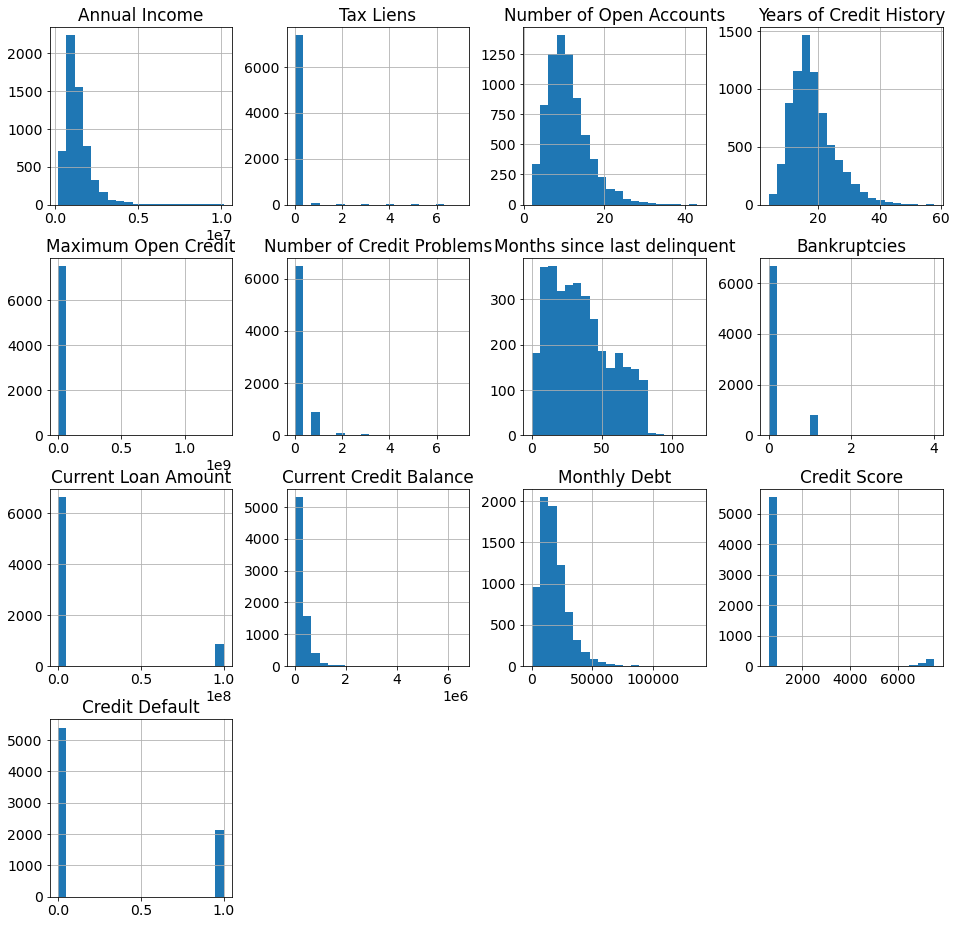

In [13]:
# Обзор признаков
train_df.hist(bins = 20, figsize = (16, 16))
plt.show()


## Матрица корреляции

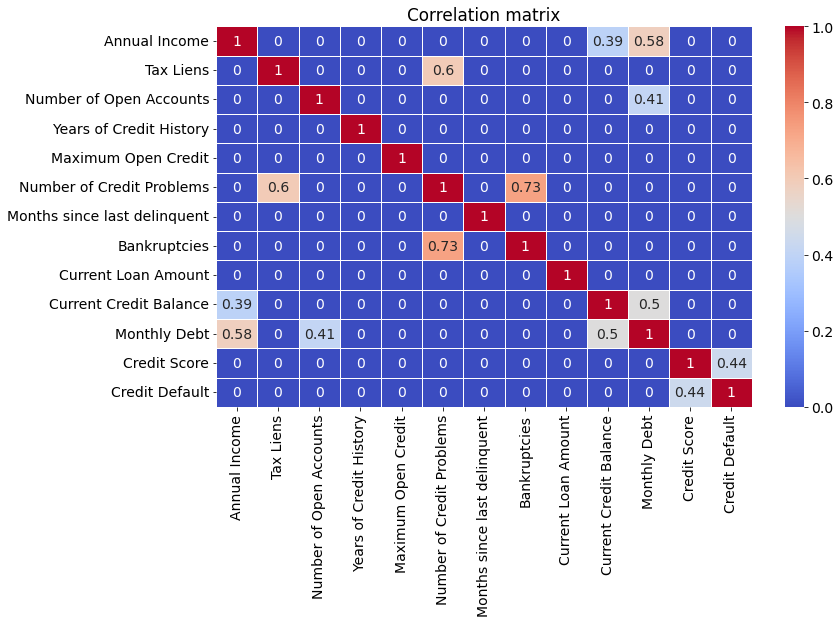

In [14]:
plt.figure(figsize=(12, 7))


corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Обработка пропусков

In [15]:
# NAN - пропуски в данных
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [16]:
test_df.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [17]:
# Заменим NAN на 0
train_df = train_df.fillna(0) 
test_df = test_df.fillna(0)

In [18]:
# Обработка Annual Income 
# Меняем 0 на median
train_df.loc[train_df['Annual Income'] == 0, 'Annual Income'] = train_df['Annual Income'].median()
test_df.loc[test_df['Annual Income'] == 0, 'Annual Income'] = test_df['Annual Income'].median()

In [19]:
train_df['Annual Income'].head(10)

0     482087.0
1    1025487.0
2     751412.0
3     805068.0
4     776264.0
5     989130.5
6    1511108.0
7    1040060.0
8     989130.5
9     989130.5
Name: Annual Income, dtype: float64

In [20]:
# Обработка Years in current job
# Меняем 0 на mode
train_df.loc[train_df['Years in current job'] == 0, 'Years in current job'] = train_df['Years in current job'].mode()[0]
test_df.loc[test_df['Years in current job'] == 0, 'Years in current job'] = test_df['Years in current job'].mode()[0]

In [21]:
train_df['Years in current job'].sort_values().unique()

array(['1 year', '10+ years', '2 years', '3 years', '4 years', '5 years',
       '6 years', '7 years', '8 years', '9 years', '< 1 year'],
      dtype=object)

In [22]:
# Обработка  Months since last delinquent
# Меняем 0 на median
train_df.loc[train_df['Months since last delinquent'] == 0, 'Months since last delinquent'] = train_df['Months since last delinquent'].median()
test_df.loc[test_df['Months since last delinquent'] == 0, 'Months since last delinquent'] = test_df['Months since last delinquent'].median()

In [23]:
# Обработка  Bankruptcies
# Меняем на median
train_df.loc[train_df['Bankruptcies'] == 0, 'Bankruptcies'] = train_df['Bankruptcies'].median()
test_df.loc[test_df['Bankruptcies'] == 0, 'Bankruptcies'] = test_df['Bankruptcies'].median()

In [24]:
train_df['Bankruptcies'].head(10)

0    1.0
1    0.0
2    0.0
3    1.0
4    0.0
5    0.0
6    0.0
7    0.0
8    1.0
9    0.0
Name: Bankruptcies, dtype: float64

In [25]:
# Обработка  Credit Score  
# Меняем 0 на median
train_df.loc[train_df['Credit Score'] == 0, 'Credit Score'] = train_df['Credit Score'].median()
test_df.loc[test_df['Credit Score'] == 0, 'Credit Score'] = test_df['Credit Score'].median()

In [26]:
#Нормализация
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
X = train_df.drop(["Credit Default"], axis=1)
y = train_df["Credit Default"]




In [27]:
#Нормализация
for f in test_df.columns:
    if test_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))
test_df = test_df

In [28]:
def set_NAN_mean (df, col):
    df.loc[df['col'] == 0, 'col'] = df['col'].median()

In [29]:
catcols = [
    'Home Ownership', 'Years in current job', 'Tax Liens',
    'Number of Open Accounts', 'Number of Credit Problems','Months since last delinquent',
    'Bankruptcies', 'Purpose', 'Term']



# Построение модели

## Разбиение на train и test

In [30]:
train_df[catcols] = train_df[catcols].astype(int)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 3910 to 7113
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                5250 non-null   int64  
 1   Annual Income                 5250 non-null   float64
 2   Years in current job          5250 non-null   int64  
 3   Tax Liens                     5250 non-null   float64
 4   Number of Open Accounts       5250 non-null   float64
 5   Years of Credit History       5250 non-null   float64
 6   Maximum Open Credit           5250 non-null   float64
 7   Number of Credit Problems     5250 non-null   float64
 8   Months since last delinquent  5250 non-null   float64
 9   Bankruptcies                  5250 non-null   float64
 10  Purpose                       5250 non-null   int64  
 11  Term                          5250 non-null   int64  
 12  Current Loan Amount           5250 non-null   float64
 13  

## Выбор модели

# XGBoost

In [33]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)

y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[16:38:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3771
           1       0.99      0.87      0.93      1479

    accuracy                           0.96      5250
   macro avg       0.97      0.93      0.95      5250
weighted avg       0.96      0.96      0.96      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1616
           1       0.60      0.35      0.44       634

    accuracy                           0.75      2250
   macro avg       0.69      0.63      0.64      2250
weighted avg       0.73      0.75      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0          

# CATBOOST

In [34]:
import catboost as catb

In [35]:
%%time

final_model_CB = catb.CatBoostClassifier(
                                     silent=True, 
                                     random_state=21,
                                     class_weights=[1, 2.3],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=200,
                                     max_depth=6,
                                     min_data_in_leaf=5,
                                     l2_leaf_reg=20,
                                     )


final_model_CB.fit(X_train, y_train)

y_train_pred = final_model_CB.predict(X_train)
y_test_pred = final_model_CB.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3771
           1       0.59      0.65      0.62      1479

    accuracy                           0.78      5250
   macro avg       0.73      0.74      0.73      5250
weighted avg       0.78      0.78      0.78      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1616
           1       0.52      0.57      0.54       634

    accuracy                           0.73      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.74      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1278  338
1                274  360
CPU times: user 2.17 s, sys: 324 ms, total: 2.5 s
Wall time: 1.17 s


# Итоговый ответ

In [36]:
test_df.shape

(2500, 16)

In [37]:
test_df.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2500.000000,2.500000e+03,2500.0000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,2500.000000
mean,1.912400,1.290916e+06,3.6304,0.035200,11.184400,18.325920,7.105704e+05,0.162000,15.614000,0.106800,3.752000,0.744400,1.215572e+07,2.963966e+05,18271.340000,1129.348400
std,0.949677,8.311658e+05,3.1542,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.616348,0.356994,2.033753,0.436285,3.226097e+07,3.783020e+05,11543.881469,1565.104518
min,0.000000,1.065330e+05,0.0000,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,1.000000,9.365622e+05,1.0000,0.000000,8.000000,13.400000,2.785860e+05,0.000000,0.000000,0.000000,3.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,717.000000
50%,2.000000,9.968302e+05,2.0000,0.000000,10.000000,17.000000,4.786760e+05,0.000000,0.000000,0.000000,3.000000,1.000000,3.223660e+05,2.073850e+05,16642.500000,722.000000
75%,3.000000,1.488726e+06,6.0000,0.000000,14.000000,22.100000,8.025985e+05,0.000000,27.000000,0.000000,3.000000,1.000000,5.225825e+05,3.663485e+05,24146.000000,741.000000
max,3.000000,1.497561e+07,10.0000,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,13.000000,1.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [38]:
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,3,996521.5,4,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,3,1,162470.0,105906.0,6813.0,722.0
1,3,231838.0,0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,4,1,78298.0,46037.0,2318.0,699.0
2,1,1152540.0,3,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,3,1,200178.0,146490.0,18729.0,7260.0
3,1,1220313.0,1,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,3,1,217382.0,213199.0,27559.0,739.0
4,1,2340952.0,6,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,3,0,777634.0,425391.0,42605.0,706.0


In [39]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   int64  
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   int64  
 11  Term                          2500 non-null   int64  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [40]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [41]:
predictions = final_model_CB.predict(test_df)
predictions

array([0, 1, 1, ..., 1, 0, 1])

In [42]:
predictions.shape

(2500,)

In [43]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0


In [44]:
submit.to_csv('Credit_ls_submit.csv', index=False)